In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
from sklearn.datasets import make_classification

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [8]:
import matplotlib.pyplot as plt

In [9]:
import tensorflow as tf

In [10]:
from tensorflow import keras

In [11]:
from tensorflow.keras import layers, callbacks

In [12]:
# reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [13]:
# 1) Create synthetic imbalanced dataset (1% anomalies)
X, y_raw = make_classification(n_samples=10000, n_features=20, n_informative=15,
                               n_redundant=5, weights=[0.01, 0.99],
                               flip_y=0, random_state=RANDOM_SEED)

In [14]:
# Map labels so: 1 = normal, 0 = anomaly (matches your lab note)
y = y_raw.copy()

In [15]:
# 2) Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25,
                                                              stratify=y, random_state=RANDOM_SEED)

In [16]:
# Train autoencoder only on normal samples:
X_train = X_train_full[y_train_full == 1]

In [17]:
# 3) Scale (fit scaler on normal train)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# 4) Build autoencoder
input_dim = X_train_scaled.shape[1]
encoding_dim = 8

In [19]:
inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
encoded = layers.Dense(encoding_dim, activation="relu", name="latent")(x)

In [20]:
x = layers.Dense(32, activation="relu")(encoded)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(input_dim, activation="linear")(x)

In [21]:
autoencoder = keras.Model(inputs, outputs, name="autoencoder")
autoencoder.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mse"])

In [22]:
# 5) Train (with early stopping)
es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=100, batch_size=64, validation_split=0.1,
                          callbacks=[es], verbose=2)

Epoch 1/100
105/105 - 11s - 108ms/step - loss: 0.7551 - mse: 0.7551 - val_loss: 0.5075 - val_mse: 0.5075
Epoch 2/100
105/105 - 1s - 11ms/step - loss: 0.4045 - mse: 0.4045 - val_loss: 0.3262 - val_mse: 0.3262
Epoch 3/100
105/105 - 1s - 10ms/step - loss: 0.2801 - mse: 0.2801 - val_loss: 0.2642 - val_mse: 0.2642
Epoch 4/100
105/105 - 1s - 10ms/step - loss: 0.2388 - mse: 0.2388 - val_loss: 0.2333 - val_mse: 0.2333
Epoch 5/100
105/105 - 1s - 10ms/step - loss: 0.2127 - mse: 0.2127 - val_loss: 0.2084 - val_mse: 0.2084
Epoch 6/100
105/105 - 1s - 10ms/step - loss: 0.1959 - mse: 0.1959 - val_loss: 0.1924 - val_mse: 0.1924
Epoch 7/100
105/105 - 1s - 9ms/step - loss: 0.1854 - mse: 0.1854 - val_loss: 0.1832 - val_mse: 0.1832
Epoch 8/100
105/105 - 1s - 10ms/step - loss: 0.1790 - mse: 0.1790 - val_loss: 0.1781 - val_mse: 0.1781
Epoch 9/100
105/105 - 1s - 13ms/step - loss: 0.1747 - mse: 0.1747 - val_loss: 0.1754 - val_mse: 0.1754
Epoch 10/100
105/105 - 1s - 11ms/step - loss: 0.1716 - mse: 0.1716 - val

In [23]:
# 6) Reconstruction error
recon_train = autoencoder.predict(X_train_scaled)
mse_train = np.mean(np.square(recon_train - X_train_scaled), axis=1)

233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [24]:
recon_test = autoencoder.predict(X_test_scaled)
mse_test = np.mean(np.square(recon_test - X_test_scaled), axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [25]:
# 7) Threshold selection (two common ways)
threshold_mean_std = mse_train.mean() + 3 * mse_train.std()
threshold_95 = np.percentile(mse_train, 95)
threshold = threshold_95  # choose one to use

In [26]:
# 8) Predictions: predict anomaly if reconstruction error > threshold
y_pred = np.where(mse_test > threshold, 0, 1)

In [27]:
# 9) Evaluation
print("Confusion matrix (true 0/1 rows, pred 0/1 cols):")
print(confusion_matrix(y_test, y_pred, labels=[0,1]))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion matrix (true 0/1 rows, pred 0/1 cols):
[[  21    4]
 [ 165 2310]]

Classification report:
              precision    recall  f1-score   support

           0     0.1129    0.8400    0.1991        25
           1     0.9983    0.9333    0.9647      2475

    accuracy                         0.9324      2500
   macro avg     0.5556    0.8867    0.5819      2500
weighted avg     0.9894    0.9324    0.9571      2500



In [28]:
# AUC (use recon error as score for anomaly)
y_test_anom = (y_test == 0).astype(int)  # 1 for anomaly
auc = roc_auc_score(y_test_anom, mse_test)
print(f"ROC AUC = {auc:.4f}")

ROC AUC = 0.9707


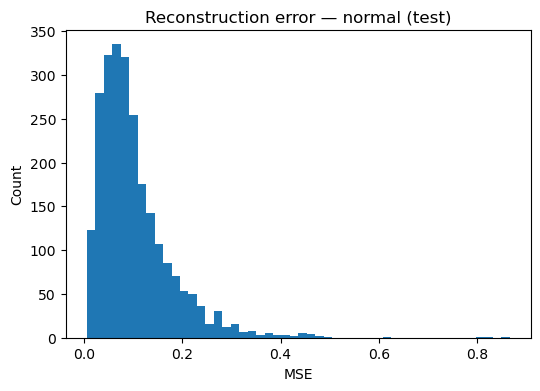

In [29]:
# 10) Plots - one chart per figure (matplotlib default)
mse_test_normal = mse_test[y_test == 1]
plt.figure(figsize=(6,4))
plt.hist(mse_test_normal, bins=50)
plt.title("Reconstruction error — normal (test)")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.show()

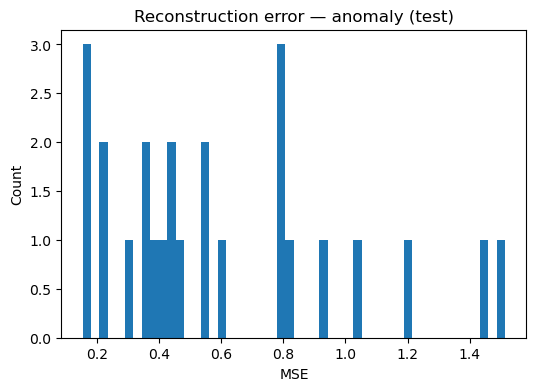

In [30]:
mse_test_anom = mse_test[y_test == 0]
plt.figure(figsize=(6,4))
plt.hist(mse_test_anom, bins=50)
plt.title("Reconstruction error — anomaly (test)")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.show()